# Initialization

Notebook for the C-MAPPS benchmark. Plot the real vs the predicted RUL 

First we import the necessary packages and create the global variables.

In [1]:
import math
import numpy as np
import csv
import copy
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import model_from_json, clone_model

from data_handler_CMAPS import CMAPSDataHandler
import custom_scores
import CMAPSAuxFunctions
from tunable_model import SequenceTunableModelRegression
from keras import regularizers

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Function to plot RULs

In [27]:
def plot_RUL(real_rul_list, predicted_rul_list):
    
    for real_rul, predicted_rul, i in zip(real_rul_list, predicted_rul_list, range(len(real_rul_list))):
    
        #print(i)
        
        x = np.arange(1,real_rul.shape[0]+1)
        e = real_rul-predicted_rul
        #print(e)
        
        fig = plt.figure(i)
        fig.suptitle('Real RUL vs Predicted RUL', fontsize=14)
        #plt.title('Real RUL vs Predicted RUL')
        
        plt.subplot(2,1,1)
        plt.xlabel("Engine Number")
        plt.ylabel("RUL")
        plt.plot(x, predicted_rul, 'r--')
        plt.plot(x, real_rul, 'g--')
        plt.legend(('Predicted RUL', 'Real RUL'), loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.subplot(2,1,2)
        plt.xlabel("Engine Number")
        plt.ylabel("Prediction Error")
        plt.plot(x, e, 'm--')
        
        plt.savefig('rul_plots_dataset_'+str(i)+'.png')

# Create data Handler

In [3]:
#Selected as per CNN paper
features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
selected_features = list(features[i] for i in selected_indices-1)
data_folder = '../CMAPSSData'

window_size = 30
window_stride = 1
max_rul = 125

dHandler_cmaps = CMAPSDataHandler(data_folder, 1, selected_features, max_rul, window_size, window_stride)
#dHandler_cmaps.load_data(verbose=1, cross_validation_ratio=0.2)

# Load models and get predicted and real RULs

In [4]:
datasets = [1, 2, 3, 4]

window_sizes = {1:24,2:17,3:24,4:17}
strides = {1:1,2:1,3:1,4:1}
max_ruls = {1:129, 2:139, 3:129, 4:139}

y_predicted_list = []
y_true_list = []


for i in datasets:

    # load json and create model
    json_file = open('bestRULModel_dataset_'+str(i)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("bestRULModel_dataset_"+str(i)+".h5")
    print("Loaded model from disk")


    #Shared parameters for the models
    optimizer = Adam(lr=0, beta_1=0.5)
    lossFunction = "mean_squared_error"
    metrics = ["mse"]

    #Selected as per CNN paper
    selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                         'BPR', 'htBleed', 'W31', 'W32']

    #Create and compile the models
    #nFeatures = len(selected_features)
    #shapeSN = nFeatures*windowSize
    #modelRULSN = RULmodel_SN_1(shapeSN)
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)

    #min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    min_max_scaler = MinMaxScaler()

    tModel = SequenceTunableModelRegression('ModelRUL_SN_1', loaded_model, lib_type='keras', data_handler=dHandler_cmaps)

    tModel.data_handler.change_dataset(i)
    tModel.data_handler.sequence_length = window_sizes[i]
    tModel.data_handler.sequence_stride = strides[i]
    tModel.data_handler.max_rul = max_ruls[i]

    tModel.data_handler.data_scaler = None
    tModel.data_scaler = min_max_scaler

    tModel.load_data(unroll=True, verbose=1, cross_validation_ratio=0)
    #tModel.print_data()
    #print(tModel.model.get_weights())
    tModel.get_model_description()
    
    # evaluate loaded model on test data
    tModel.evaluate_model(['rhs', 'rmse'], round=2)
    print("scores")

    #print(tModel.y_pred)

    cScores = tModel.scores
    print(cScores)
    rmse = math.sqrt(cScores['score_1'])
    rmse2 = cScores['rmse']
    rhs = cScores['rhs']
    time = tModel.train_time
    
    y_predicted = tModel.y_predicted_rounded.flatten()
    y_true = tModel.y_test.flatten()
    
    y_predicted_list.append(y_predicted)
    y_true_list.append(y_true)

    print(cScores)
    print("RMSE: {}".format(rmse))
    print("RMSE2: {}".format(rmse2))
    print("RHS: {}".format(rhs))
    print("Time : {} seconds".format(time))

Loaded model from disk
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes
Description for model: ModelRUL_SN_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 20)                6740      
_________________________________________________________________
fc2 (Dense)                  (None, 20)                420       
_________________________________________________________________
out (Dense)                  (None, 1)                 21        
Total params: 7,181
Trainable params: 7,181
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 0s 1ms/step
scores
{'loss': 270.6421185302734, 'score_1': 206.36581756591798, 'rhs': 3.4385813531834817, 'rmse': 14.358272876638054}
{'loss': 270.6

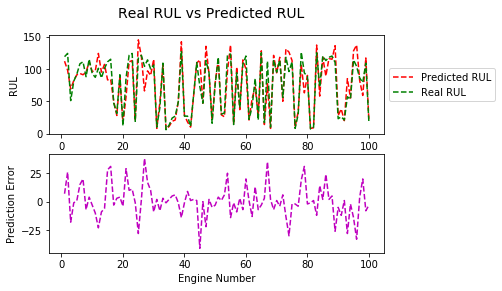

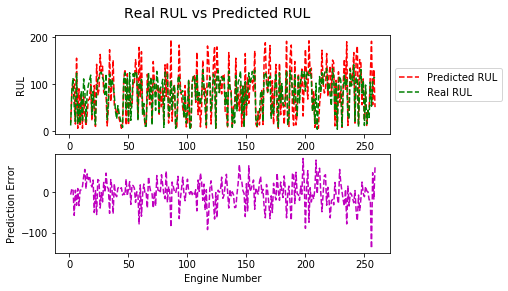

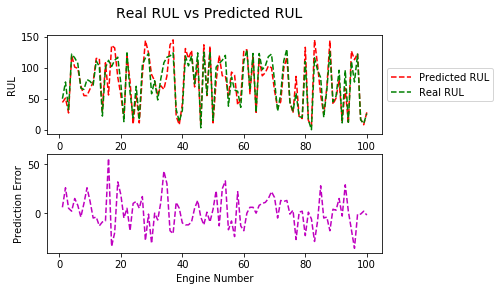

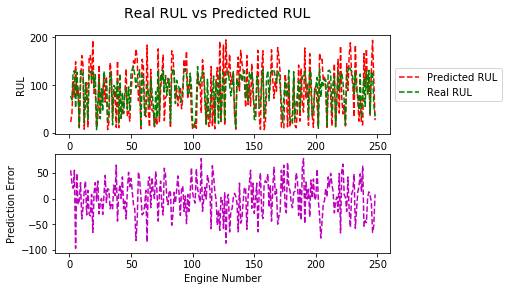

In [28]:
plot_RUL(y_predicted_list, y_true_list)